In [ ]:
import glob
import shutil

pre_list = glob.glob('/content/*.hdf5')
for p in pre_list :
  shutil.copy(p, '/content/drive/My Drive/maestro-v1.0.0/pre_trained')

In [ ]:
import glob
import shutil

pre_list = glob.glob('/content/drive/My Drive/maestro-v1.0.0/pre_trained/*.hdf5')
for p in pre_list :
  shutil.copy(p, '/content/')

In [ ]:
!pip install magenta

     |████████████████████████████████| 1.4MB 9.2MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 1.5MB 29.2MB/s 
     |████████████████████████████████| 2.3MB 38.8MB/s 
     |████████████████████████████████| 1.6MB 36.2MB/s 
     |████████████████████████████████| 3.6MB 38.9MB/s 
     |████████████████████████████████| 5.6MB 32.1MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
     |████████████████████████████████| 204kB 38.3MB/s 
     |████████████████████████████████| 358kB 40.1MB/s 
     |████████████████████████████████| 256kB 45.8MB/s 
     |████████████████████████████████| 215kB 44.5MB/s 
     |████████████████████████████████| 368kB 39.9MB/s 
     |████████████████████████████████| 5.6MB 25.4MB/s 
     |████████████████████████████████| 194kB 46.4MB/s 
     |████████████████████████████████| 686kB 35.3MB/s 
     |████████████████████████████████| 368kB 44.7MB/s 
     |████████████████████████████████| 655kB 35.1MB/

In [ ]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from glob import glob

import numpy as np

from tensorflow                                  import __version__
from tensorflow.test                             import is_built_with_cuda, is_gpu_available, gpu_device_name
from tensorflow.python.client                    import device_lib

print('\nTensorflow version = {},\nbuilt with CUDA\t= {},\nGPU available\t= {},\nGPU device name = {}\n\nAll devices: {}'
      .format(__version__, is_built_with_cuda(), is_gpu_available(), gpu_device_name(), device_lib.list_local_devices()))

from tensorflow.compat.v1                        import Session
from tensorflow.python.training.checkpoint_utils import list_variables, load_variable

from keras                 import backend as K
from keras.layers          import Activation, BatchNormalization, Bidirectional, concatenate, \
                                  Conv2D, Dense, Input, LSTM, MaxPool2D, Reshape
from keras.models          import load_model, Model

from librosa               import midi_to_hz
from sklearn.metrics       import auc, roc_curve
from sklearn.preprocessing import binarize

from note_seq.sequences_lib                             import pianoroll_to_note_sequence
from magenta.models.onsets_frames_transcription.metrics import sequence_to_valued_intervals
from mir_eval.transcription                             import precision_recall_f1_overlap as Overlap
from mir_eval.transcription_velocity                    import precision_recall_f1_overlap as OverlapVolumes

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Tensorflow version = 2.5.0,
built with CUDA	= True,
GPU available	= True,
GPU device name = /device:GPU:0

All devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1348344033429680327
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1573532759873603513
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = '/content/drive/My Drive/maestro-v1.0.0', -87, -86, -31, -30, 40, 41

melsVal = np.load(dataFolder + '/Mels validation.npy')
print(len(melsVal), 'validation samples,', end='\t')
melsValMin, melsValMean, melsValMax = melsVal.min(), melsVal.mean(), melsVal.max()

print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsValMin, melsValMean, melsValMax))

onVal, offVal, actVal, volsVal = map(np.load, ['{}/{} validation.npy'.format(
    dataFolder, name) for name in ['Onsets', 'Offsets', 'Actives', 'Volumes']])
volsValMin, volsValMean, volsValMax = volsVal.min(), volsVal.mean(), volsVal.max()
assert volsValMin == 0 and 0 < volsValMax <= 1, 'Wrong normalized MIDI volumes range'
print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(volsValMin, volsValMean, volsValMax))

1082 validation samples,	Mels decibels in range [-78 ... -30 ... 40]
Midi normalized volumes in range [0.0 ... 0.0035 ... 0.98]


Instead of training my own model, I just copy the weights from the Google's pre-trained tensorflow checkpoint:
https://storage.googleapis.com/magentadata/models/onsets_frames_transcription/maestro_checkpoint.zip
(or look for the link here: https://github.com/tensorflow/magenta/tree/master/magenta/models/onsets_frames_transcription)

In [ ]:
!wget https://storage.googleapis.com/magentadata/models/onsets_frames_transcription/maestro_checkpoint.zip

--2021-07-08 06:42:33--  https://storage.googleapis.com/magentadata/models/onsets_frames_transcription/maestro_checkpoint.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263865474 (252M) [application/zip]
Saving to: ‘maestro_checkpoint.zip’

maestro_checkpoint. 100%[===================>] 251.64M   116MB/s    in 2.2s    

2021-07-08 06:42:36 (116 MB/s) - ‘maestro_checkpoint.zip’ saved [263865474/263865474]



In [ ]:
!unzip maestro_checkpoint.zip

Archive:  maestro_checkpoint.zip
   creating: train/
  inflating: train/model.ckpt.data-00000-of-00001  
  inflating: train/model.ckpt.meta   
  inflating: train/model.ckpt.index  
  inflating: train/checkpoint        


In [ ]:
cptDir, lstmWidth, inputs = 'train', 256, Input(shape=(melsVal.shape[1], melsVal.shape[2]))

ConvBnRelu = lambda n: lambda x: Activation('relu')(BatchNormalization(scale=False)(
    Conv2D(n, 3, padding='same', use_bias=False)(x)))
outputs = MaxPool2D((1, 2))(ConvBnRelu(96)(MaxPool2D((1, 2))(ConvBnRelu(48)(
    ConvBnRelu(48)(Reshape((melsVal.shape[1], melsVal.shape[2], 1))(inputs))))))

model = Model(inputs, Dense(88, activation='sigmoid')(Bidirectional(LSTM(lstmWidth,
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell_impl.py#L782
    # Sigmoid activation for hidden units, also unroll must be True, otherwise weights will be different
    # Cannot use stateful mode because backward LSTM would require reversed batch:
    recurrent_activation='sigmoid', implementation=2, return_sequences=True, unroll=True))(Dense(768, activation='relu')(
    Reshape((K.int_shape(outputs)[1], K.int_shape(outputs)[2] * K.int_shape(outputs)[3]))(outputs)))))

for i in [2, 3, 5, 6, 9, 10, 14, 15, 16]:
#    print(*model.layers[i].weights, sep='\n', end='\n\n')
    print()
    for weights in model.layers[i].weights:
        print(weights.name, weights.shape, sep='\t', end='\n')
print()
with Session() as sess: print(*['{}\t{}'.format(name, shape) for name, shape in list_variables(cptDir)], sep='\n')
model.summary()


conv2d/kernel:0	(3, 3, 1, 48)

batch_normalization/beta:0	(48,)
batch_normalization/moving_mean:0	(48,)
batch_normalization/moving_variance:0	(48,)

conv2d_1/kernel:0	(3, 3, 48, 48)

batch_normalization_1/beta:0	(48,)
batch_normalization_1/moving_mean:0	(48,)
batch_normalization_1/moving_variance:0	(48,)

conv2d_2/kernel:0	(3, 3, 48, 96)

batch_normalization_2/beta:0	(96,)
batch_normalization_2/moving_mean:0	(96,)
batch_normalization_2/moving_variance:0	(96,)

dense_1/kernel:0	(480, 768)
dense_1/bias:0	(768,)

bidirectional/forward_lstm/lstm_cell_1/kernel:0	(768, 1024)
bidirectional/forward_lstm/lstm_cell_1/recurrent_kernel:0	(256, 1024)
bidirectional/forward_lstm/lstm_cell_1/bias:0	(1024,)
bidirectional/backward_lstm/lstm_cell_2/kernel:0	(768, 1024)
bidirectional/backward_lstm/lstm_cell_2/recurrent_kernel:0	(256, 1024)
bidirectional/backward_lstm/lstm_cell_2/bias:0	(1024,)

dense/kernel:0	(512, 88)
dense/bias:0	(88,)

beta1_power	[]
beta2_power	[]
frame/activation_probs/biases	[88]
f

In [ ]:
def MagentaToKeras(modelName, xVal, yVal):
    numLayers, varName, varProbName = 16, modelName.lower(), None
    
    for i, j in zip(range(3), [2, 5, 9]):
        model.layers[j    ].set_weights([load_variable(cptDir, '{}/conv{}/weights'     .format(varName, i))])
        model.layers[j + 1].set_weights([load_variable(cptDir, '{}/conv{}/BatchNorm/{}'.format(varName, i, name))
                                         for name in ['beta', 'moving_mean', 'moving_variance']])
    model.layers[14].set_weights([load_variable(cptDir, '{}/fc_end/{}'.format(varName, name))
                                  for name in ['weights', 'biases']])
    
    if modelName in ['Onsets', 'Offsets']: varProbName = varName[:-1] + '_probs'
    elif modelName == 'Velocity': numLayers, varProbName = 15, 'onset_velocities'
    else:
        assert modelName == 'Frame', 'Illegal model name'
        numLayers, varProbName = 20, 'frame_probs'
        model.layers[16].set_weights([load_variable(cptDir, 'frame/activation_probs/{}'.format(name))
                                      for name in ['weights', 'biases']])

    if modelName != 'Velocity':
        fW, fB, bW, bB = [load_variable(cptDir, '{}/cudnn_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/'
            '{}/cudnn_compatible_lstm_cell/{}'.format(varName, fb, kb)) for fb in ['fw', 'bw'] for kb in ['kernel', 'bias']]
        # https://stackoverflow.com/questions/48212694/in-what-order-are-weights-saved-in-a-lstm-kernel-in-tensorflow
        # Tensorflow order is I-C-F-O:
        (fWi, fWc, fWf, fWo), (bWi, bWc, bWf, bWo) = map(lambda arr: np.split(arr, 4, 1), [fW, bW])
        (fBi, fBc, fBf, fBo), (bBi, bBc, bBf, bBo) = map(lambda arr: np.split(arr, 4),    [fB, bB])
        # https://stackoverflow.com/questions/47661105/order-of-lstm-weights-in-keras
        # Keras order is I-F-C-O:
        fWk, bWk, fBk, bBk = map(np.hstack, [[fWi, fWf, fWc, fWo], [bWi, bWf, bWc, bWo],
                                             [fBi, fBf, fBc, fBo], [bBi, bBf, bBc, bBo]])
        # https://stats.stackexchange.com/questions/280995/accessing-lstm-weights-tensors-in-tensorflow
        # Input units first, then hidden (recurrent) nodes:
        model.layers[numLayers - 1].set_weights([fWk[:-lstmWidth], fWk[-lstmWidth:], fBk,
                                                 bWk[:-lstmWidth], bWk[-lstmWidth:], bBk])

    model.layers[numLayers].set_weights([load_variable(cptDir, '{}/{}/{}'.format(
        varName, varProbName, name)) for name in ['weights', 'biases']])
    model.save('Magenta {} {:.2f}.hdf5'.format(modelName, model.evaluate(
        xVal, yVal, 32, 1)[1] * 100), include_optimizer=False)

def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1. if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Onsets', melsVal, onVal)
onProb = model.predict(melsVal, 16, 1)

MagentaToKeras('Offsets', melsVal, offVal)
offProb = model.predict(melsVal, 16, 1)

def VolAcc(yTrue, yPred):
    onsets = K.cast(yTrue > K.epsilon(), float)
    yPredOnsets, numNotes = yPred * onsets, K.sum(onsets)
    
    # Linear regression:
    sumX, sumY = map(K.sum, (yPredOnsets, yTrue))
    m = (numNotes * K.sum(yPredOnsets * yTrue) - sumX * sumY) / (numNotes * K.sum(yPredOnsets ** 2) - sumX ** 2)
    yPredOnsets = (m * yPredOnsets + (sumY - m * sumX) / numNotes) * onsets
    
    return (numNotes - K.sum(K.cast(K.abs(yPredOnsets - yTrue) > .1, float))) / numNotes

model = Model(model.input, Dense(volsVal.shape[2], activation='sigmoid')(model.layers[-3].output))
model.compile('Adam', 'categorical_crossentropy', [VolAcc])
MagentaToKeras('Velocity', melsVal, volsVal)
volsProb = model.predict(melsVal, 32, 1)

onsetsIn, offsetsIn = Input(shape=(onVal.shape[1], onVal.shape[2])), Input(shape=(offVal.shape[1], offVal.shape[2]))
model = Model([onsetsIn, model.input, offsetsIn], Dense(actVal.shape[2], activation='sigmoid')(
    Bidirectional(LSTM(lstmWidth, recurrent_activation='sigmoid', implementation=2, return_sequences=True,
                       unroll=True))(concatenate([onsetsIn, model.output, offsetsIn]))))
model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Frame', [onProb, melsVal, offProb], actVal)
actProb = model.predict([onProb, melsVal, offProb], 16, 1)

68/68 [==============================] - 142s 141ms/step


# Testing for String Data

In [ ]:
fps = 16_000 / 512
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model('Magenta {}.hdf5'.format(
    name), compile=False), ['Onsets 67.90', 'Offsets 46.80', 'Frame 79.16', 'Velocity 94.26'])

for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        '/content/drive/My Drive/maestro-v1.0.0/test/2021 {}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(mels.split()[:-1])
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 16, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([onProb, m, offProb], 16, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    #assert abs(numOnsetsTrue - numOnsetsPred) < .1

['/content/drive/My', 'Drive/maestro-v1.0.0/test/2021']
	1 of 10
3/3 [==============================] - 162s 165ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 10
1/1 [==============================] - 0s 156ms/step
	3 of 10


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


1/1 [==============================] - 0s 164ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 10
1/1 [==============================] - 0s 152ms/step
	5 of 10


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


2/2 [==============================] - 0s 132ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 10
2/2 [==============================] - 0s 138ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 10
2/2 [==============================] - 0s 159ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 10
2/2 [==============================] - 0s 165ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 10
1/1 [==============================] - 0s 174ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 10
2/2 [==============================] - 0s 133ms/step

Onsets: 
Precision (specificity) = 39.23%
Recall    (sensitivity) = 49.15%
F1-score                = 43.51%

Frames: 
Precision (specificity) = 14.91%
Recall    (sensitivity) = 18.63%
F1-score                = 16.52%

Volumes:
Precision (specificity) = 14.91%
Recall    (sensitivity) = 18.63%
F1-score                = 16.52%

Actual and predicted average number of onsets: 2.04 1.64
Predicts less notes than actual (specific classifier)



/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


Onsets: 

Precision (specificity) = 39.23%

Recall    (sensitivity) = 49.15%

F1-score                = 43.51%

Frames: 

Precision (specificity) = 14.91%

Recall    (sensitivity) = 18.63%

F1-score                = 16.52%

Volumes:

Precision (specificity) = 14.91%

Recall    (sensitivity) = 18.63%

F1-score                = 16.52%


1/1 [==============================] - 0s 160ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimen

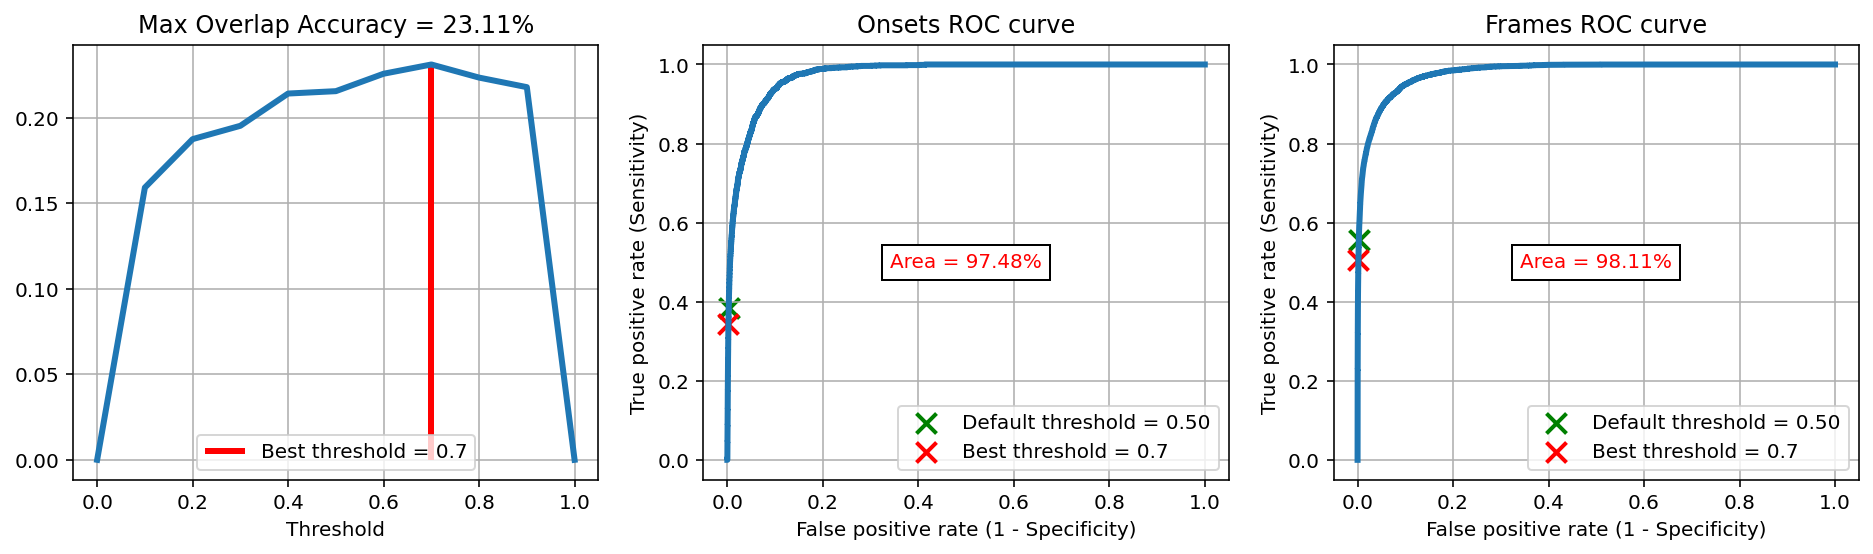

In [ ]:
mels2021, onTrue2021, offTrue2021, actTrue2021, volTrue2021 = map(lambda name: np.vstack(np.load(
    '/content/drive/My Drive/maestro-v1.0.0/test/2021/2218 {}.npy'.format(name),
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2021 = np.pad(mels2021, [(0, -len(mels2021) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2021, offProb2021, volProb2021 = map(lambda mod: mod.predict(mels2021, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2021 = activesModel.predict([onProb2021, mels2021, offProb2021], 16, 1)
onProb2021, offProb2021, actProb2021, volProb2021 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2021)], [onProb2021, offProb2021, actProb2021, volProb2021])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2021, fps, 0, onset_predictions=onTrue2021, offset_predictions=offTrue2021,
            velocity_values=volTrue2021), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2021), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2021, offProb2021, actProb2021])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2021,  onProb2021, 'Onsets')
PlotROC(3, actTrue2021, actProb2021, 'Frames')

/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


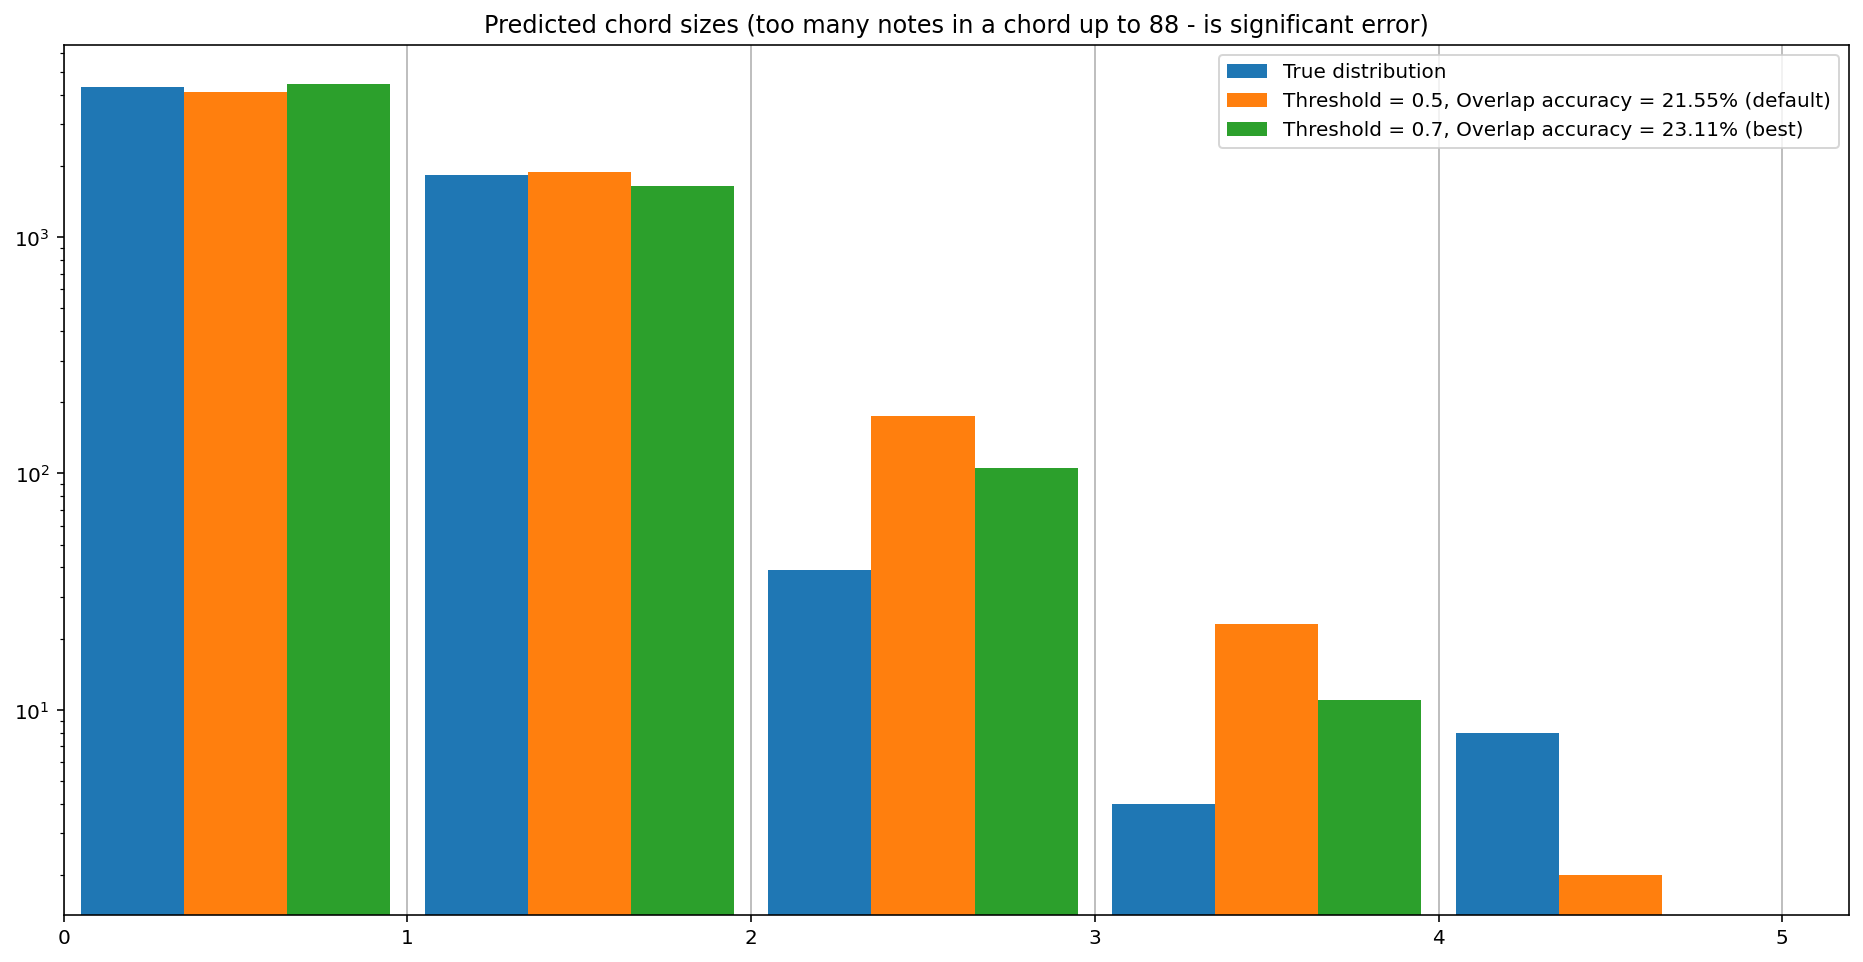

In [ ]:
yPresize, yDefault = map(lambda t: binarize(onProb2021, t).astype(int), [thBest, .5])
counts = [onTrue2021.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2021, .5),     binarize(actProb2021, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2021, thBest), binarize(actProb2021, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

2/2 [==============================] - 0s 138ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimen

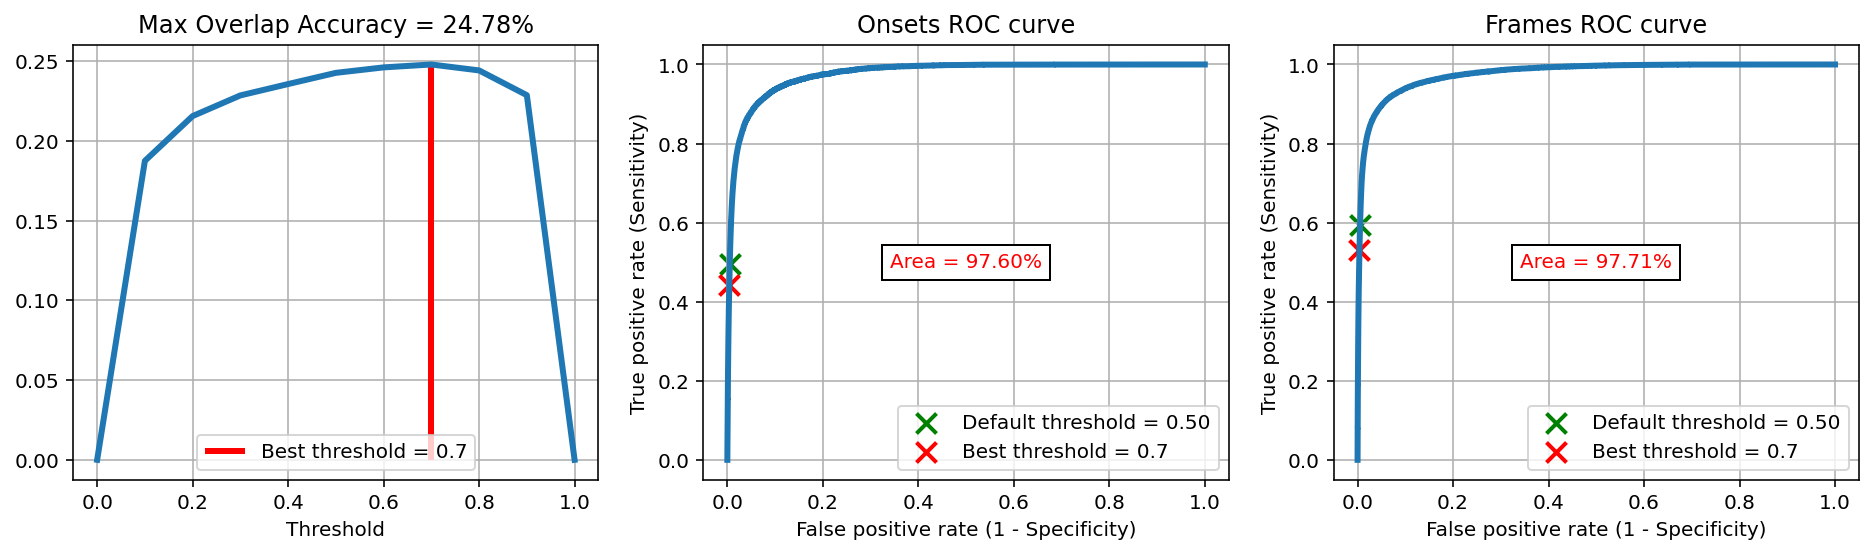

In [ ]:
mels2021, onTrue2021, offTrue2021, actTrue2021, volTrue2021 = map(lambda name: np.vstack(np.load(
#    MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 Mels
    '/content/drive/My Drive/maestro-v1.0.0/test/2021/2334 {}.npy'.format(name),
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2021 = np.pad(mels2021, [(0, -len(mels2021) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2021, offProb2021, volProb2021 = map(lambda mod: mod.predict(mels2021, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2021 = activesModel.predict([onProb2021, mels2021, offProb2021], 16, 1)
onProb2021, offProb2021, actProb2021, volProb2021 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2021)], [onProb2021, offProb2021, actProb2021, volProb2021])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2021, fps, 0, onset_predictions=onTrue2021, offset_predictions=offTrue2021,
            velocity_values=volTrue2021), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2021), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2021, offProb2021, actProb2021])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2021,  onProb2021, 'Onsets')
PlotROC(3, actTrue2021, actProb2021, 'Frames')

/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


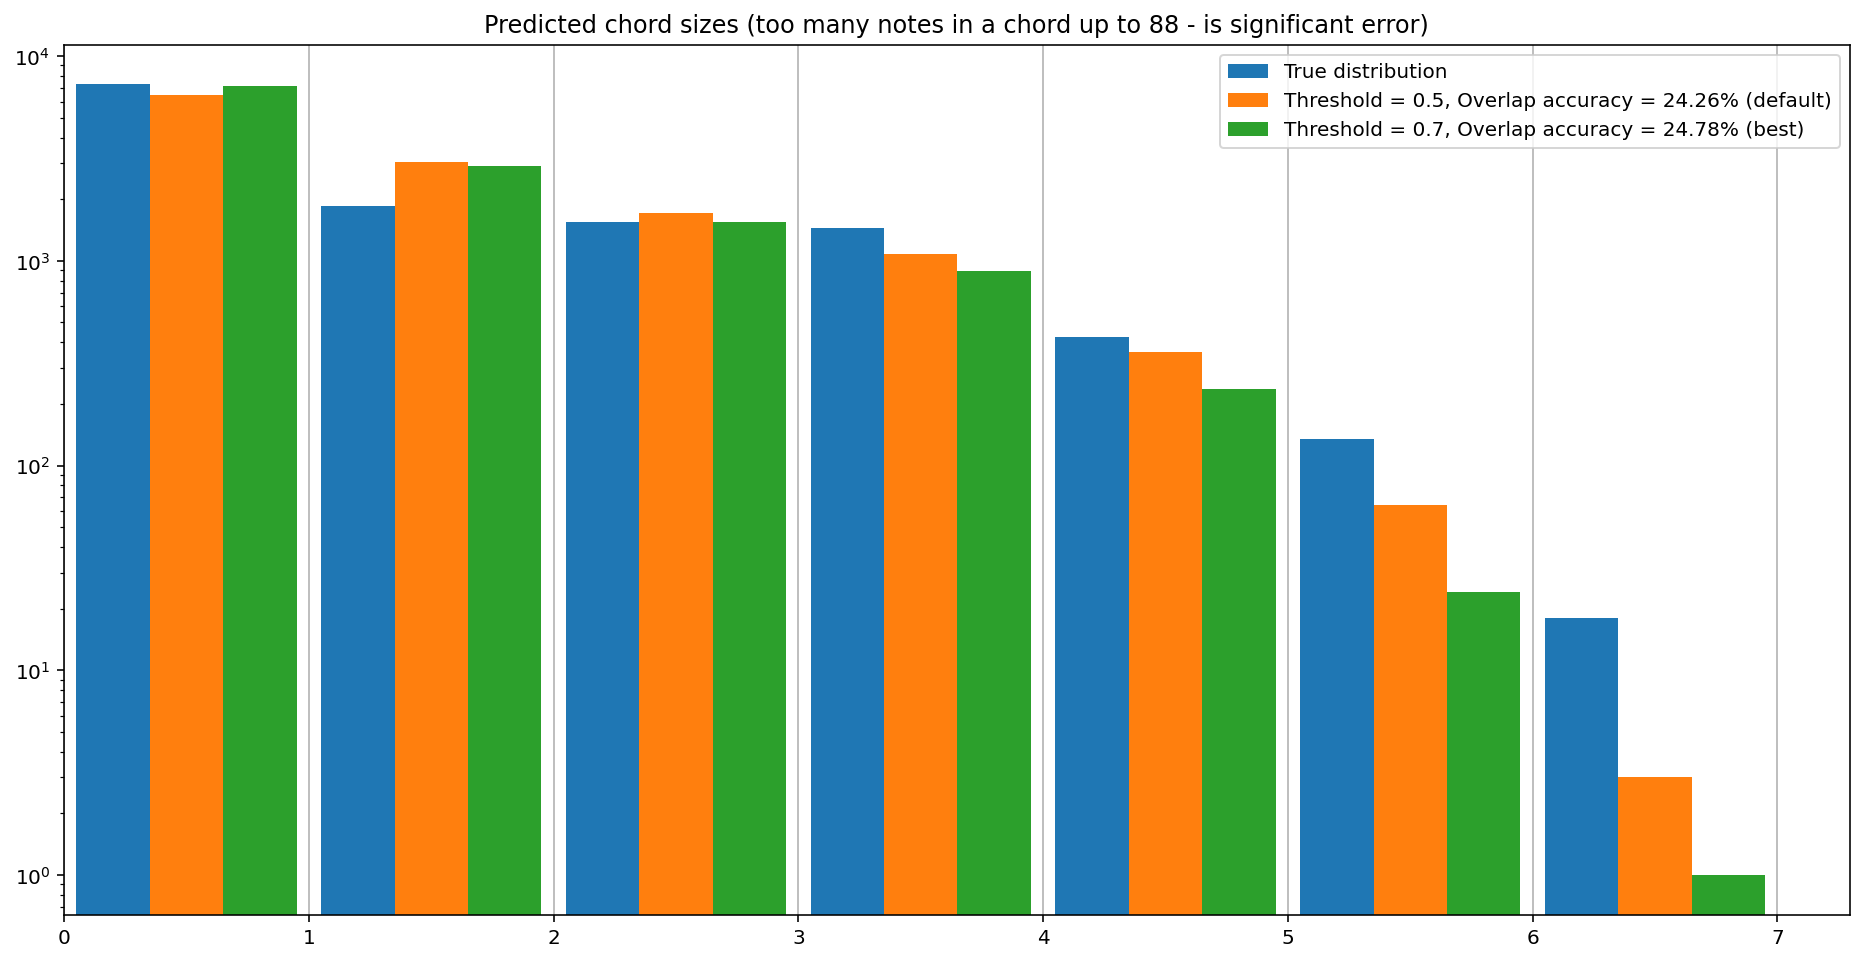

In [ ]:
yPresize, yDefault = map(lambda t: binarize(onProb2021, t).astype(int), [thBest, .5])
counts = [onTrue2021.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2021, .5),     binarize(actProb2021, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2021, thBest), binarize(actProb2021, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

# with MusicNet String Data

In [ ]:
dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = '/content/drive/My Drive/maestro-v1.0.0', -87, -86, -31, -30, 40, 41

melsVal = np.load(dataFolder + '/Mels_with validation.npy')
print(len(melsVal), 'validation samples,', end='\t')
melsValMin, melsValMean, melsValMax = melsVal.min(), melsVal.mean(), melsVal.max()
# assert melsMinMin < melsValMin < melsMinMax and melsMeanMin < melsValMean < melsMeanMax \
#     and melsMaxMin < melsValMax < melsMaxMax, 'Wrong mels decibels range'
print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsValMin, melsValMean, melsValMax))

onVal, offVal, actVal, volsVal = map(np.load, ['{}/{} validation.npy'.format(
    dataFolder, name) for name in ['Onsets_with', 'Offsets_with', 'Actives_with', 'Volumes_with']])
volsValMin, volsValMean, volsValMax = volsVal.min(), volsVal.mean(), volsVal.max()
assert volsValMin == 0 and 0 < volsValMax <= 1, 'Wrong normalized MIDI volumes range'
print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(volsValMin, volsValMean, volsValMax))

1038 validation samples,	Mels decibels in range [-78 ... -29 ... 42]
Midi normalized volumes in range [0.0 ... 0.0035 ... 0.98]


In [ ]:
cptDir, lstmWidth, inputs = 'train', 256, Input(shape=(melsVal.shape[1], melsVal.shape[2]))

ConvBnRelu = lambda n: lambda x: Activation('relu')(BatchNormalization(scale=False)(
    Conv2D(n, 3, padding='same', use_bias=False)(x)))
outputs = MaxPool2D((1, 2))(ConvBnRelu(96)(MaxPool2D((1, 2))(ConvBnRelu(48)(
    ConvBnRelu(48)(Reshape((melsVal.shape[1], melsVal.shape[2], 1))(inputs))))))

model = Model(inputs, Dense(88, activation='sigmoid')(Bidirectional(LSTM(lstmWidth,
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell_impl.py#L782
    # Sigmoid activation for hidden units, also unroll must be True, otherwise weights will be different
    # Cannot use stateful mode because backward LSTM would require reversed batch:
    recurrent_activation='sigmoid', implementation=2, return_sequences=True, unroll=True))(Dense(768, activation='relu')(
    Reshape((K.int_shape(outputs)[1], K.int_shape(outputs)[2] * K.int_shape(outputs)[3]))(outputs)))))

for i in [2, 3, 5, 6, 9, 10, 14, 15, 16]:
#    print(*model.layers[i].weights, sep='\n', end='\n\n')
    print()
    for weights in model.layers[i].weights:
        print(weights.name, weights.shape, sep='\t', end='\n')
print()
with Session() as sess: print(*['{}\t{}'.format(name, shape) for name, shape in list_variables(cptDir)], sep='\n')
model.summary()


conv2d/kernel:0	(3, 3, 1, 48)

batch_normalization/beta:0	(48,)
batch_normalization/moving_mean:0	(48,)
batch_normalization/moving_variance:0	(48,)

conv2d_1/kernel:0	(3, 3, 48, 48)

batch_normalization_1/beta:0	(48,)
batch_normalization_1/moving_mean:0	(48,)
batch_normalization_1/moving_variance:0	(48,)

conv2d_2/kernel:0	(3, 3, 48, 96)

batch_normalization_2/beta:0	(96,)
batch_normalization_2/moving_mean:0	(96,)
batch_normalization_2/moving_variance:0	(96,)

dense_1/kernel:0	(5472, 768)
dense_1/bias:0	(768,)

bidirectional/forward_lstm/lstm_cell_1/kernel:0	(768, 1024)
bidirectional/forward_lstm/lstm_cell_1/recurrent_kernel:0	(256, 1024)
bidirectional/forward_lstm/lstm_cell_1/bias:0	(1024,)
bidirectional/backward_lstm/lstm_cell_2/kernel:0	(768, 1024)
bidirectional/backward_lstm/lstm_cell_2/recurrent_kernel:0	(256, 1024)
bidirectional/backward_lstm/lstm_cell_2/bias:0	(1024,)

dense/kernel:0	(512, 88)
dense/bias:0	(88,)

beta1_power	[]
beta2_power	[]
frame/activation_probs/biases	[88]


In [ ]:
def MagentaToKeras(modelName, xVal, yVal):
    numLayers, varName, varProbName = 16, modelName.lower(), None
    
    for i, j in zip(range(3), [2, 5, 9]):
        model.layers[j    ].set_weights([load_variable(cptDir, '{}/conv{}/weights'     .format(varName, i))])
        model.layers[j + 1].set_weights([load_variable(cptDir, '{}/conv{}/BatchNorm/{}'.format(varName, i, name))
                                         for name in ['beta', 'moving_mean', 'moving_variance']])
    model.layers[14].set_weights([load_variable(cptDir, '{}/fc_end/{}'.format(varName, name))
                                  for name in ['weights', 'biases']])
    
    if modelName in ['Onsets', 'Offsets']: varProbName = varName[:-1] + '_probs'
    elif modelName == 'Velocity': numLayers, varProbName = 15, 'onset_velocities'
    else:
        assert modelName == 'Frame', 'Illegal model name'
        numLayers, varProbName = 20, 'frame_probs'
        model.layers[16].set_weights([load_variable(cptDir, 'frame/activation_probs/{}'.format(name))
                                      for name in ['weights', 'biases']])

    if modelName != 'Velocity':
        fW, fB, bW, bB = [load_variable(cptDir, '{}/cudnn_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/'
            '{}/cudnn_compatible_lstm_cell/{}'.format(varName, fb, kb)) for fb in ['fw', 'bw'] for kb in ['kernel', 'bias']]
        # https://stackoverflow.com/questions/48212694/in-what-order-are-weights-saved-in-a-lstm-kernel-in-tensorflow
        # Tensorflow order is I-C-F-O:
        (fWi, fWc, fWf, fWo), (bWi, bWc, bWf, bWo) = map(lambda arr: np.split(arr, 4, 1), [fW, bW])
        (fBi, fBc, fBf, fBo), (bBi, bBc, bBf, bBo) = map(lambda arr: np.split(arr, 4),    [fB, bB])
        # https://stackoverflow.com/questions/47661105/order-of-lstm-weights-in-keras
        # Keras order is I-F-C-O:
        fWk, bWk, fBk, bBk = map(np.hstack, [[fWi, fWf, fWc, fWo], [bWi, bWf, bWc, bWo],
                                             [fBi, fBf, fBc, fBo], [bBi, bBf, bBc, bBo]])
        # https://stats.stackexchange.com/questions/280995/accessing-lstm-weights-tensors-in-tensorflow
        # Input units first, then hidden (recurrent) nodes:
        model.layers[numLayers - 1].set_weights([fWk[:-lstmWidth], fWk[-lstmWidth:], fBk,
                                                 bWk[:-lstmWidth], bWk[-lstmWidth:], bBk])

    model.layers[numLayers].set_weights([load_variable(cptDir, '{}/{}/{}'.format(
        varName, varProbName, name)) for name in ['weights', 'biases']])
    model.save('Magenta_string {} {:.2f}.hdf5'.format(modelName, model.evaluate(
        xVal, yVal, 32, 1)[1] * 100), include_optimizer=False)

def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1. if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Onsets', melsVal, onVal)
onProb = model.predict(melsVal, 16, 1)

MagentaToKeras('Offsets', melsVal, offVal)
offProb = model.predict(melsVal, 16, 1)

def VolAcc(yTrue, yPred):
    onsets = K.cast(yTrue > K.epsilon(), float)
    yPredOnsets, numNotes = yPred * onsets, K.sum(onsets)
    
    # Linear regression:
    sumX, sumY = map(K.sum, (yPredOnsets, yTrue))
    m = (numNotes * K.sum(yPredOnsets * yTrue) - sumX * sumY) / (numNotes * K.sum(yPredOnsets ** 2) - sumX ** 2)
    yPredOnsets = (m * yPredOnsets + (sumY - m * sumX) / numNotes) * onsets
    
    return (numNotes - K.sum(K.cast(K.abs(yPredOnsets - yTrue) > .1, float))) / numNotes

model = Model(model.input, Dense(volsVal.shape[2], activation='sigmoid')(model.layers[-3].output))
model.compile('Adam', 'categorical_crossentropy', [VolAcc])
MagentaToKeras('Velocity', melsVal, volsVal)
volsProb = model.predict(melsVal, 32, 1)

onsetsIn, offsetsIn = Input(shape=(onVal.shape[1], onVal.shape[2])), Input(shape=(offVal.shape[1], offVal.shape[2]))
model = Model([onsetsIn, model.input, offsetsIn], Dense(actVal.shape[2], activation='sigmoid')(
    Bidirectional(LSTM(lstmWidth, recurrent_activation='sigmoid', implementation=2, return_sequences=True,
                       unroll=True))(concatenate([onsetsIn, model.output, offsetsIn]))))
model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Frame', [onProb, melsVal, offProb], actVal)
actProb = model.predict([onProb, melsVal, offProb], 16, 1)

65/65 [==============================] - 158s 170ms/step


# Testing for String Data

In [ ]:
fps = 16_000 / 512
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model('Magenta_string {}.hdf5'.format(
    name), compile=False), ['Onsets 53.00', 'Offsets 34.66', 'Frame 68.50', 'Velocity 95.14'])

for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        '/content/drive/My Drive/maestro-v1.0.0/test/2021 {}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(mels.split()[:-1])
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 16, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([onProb, m, offProb], 16, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    #assert abs(numOnsetsTrue - numOnsetsPred) < .1

['/content/drive/My', 'Drive/maestro-v1.0.0/test/2021']
	1 of 10
3/3 [==============================] - 166s 170ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 10
1/1 [==============================] - 0s 161ms/step
	3 of 10


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


1/1 [==============================] - 0s 157ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 10
1/1 [==============================] - 0s 158ms/step
	5 of 10


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


2/2 [==============================] - 0s 136ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 10
2/2 [==============================] - 0s 136ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 10
2/2 [==============================] - 0s 162ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 10
2/2 [==============================] - 0s 165ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 10
1/1 [==============================] - 0s 174ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 10
2/2 [==============================] - 0s 140ms/step

Onsets: 
Precision (specificity) = 39.23%
Recall    (sensitivity) = 49.15%
F1-score                = 43.51%

Frames: 
Precision (specificity) = 14.91%
Recall    (sensitivity) = 18.63%
F1-score                = 16.52%

Volumes:
Precision (specificity) = 14.91%
Recall    (sensitivity) = 18.63%
F1-score                = 16.52%

Actual and predicted average number of onsets: 2.04 1.64
Predicts less notes than actual (specific classifier)



/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


Onsets: 

Precision (specificity) = 39.23%

Recall    (sensitivity) = 49.15%

F1-score                = 43.51%

Frames: 

Precision (specificity) = 14.91%

Recall    (sensitivity) = 18.63%

F1-score                = 16.52%

Volumes:

Precision (specificity) = 14.91%

Recall    (sensitivity) = 18.63%

F1-score                = 16.52%

1/1 [==============================] - 0s 159ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimen

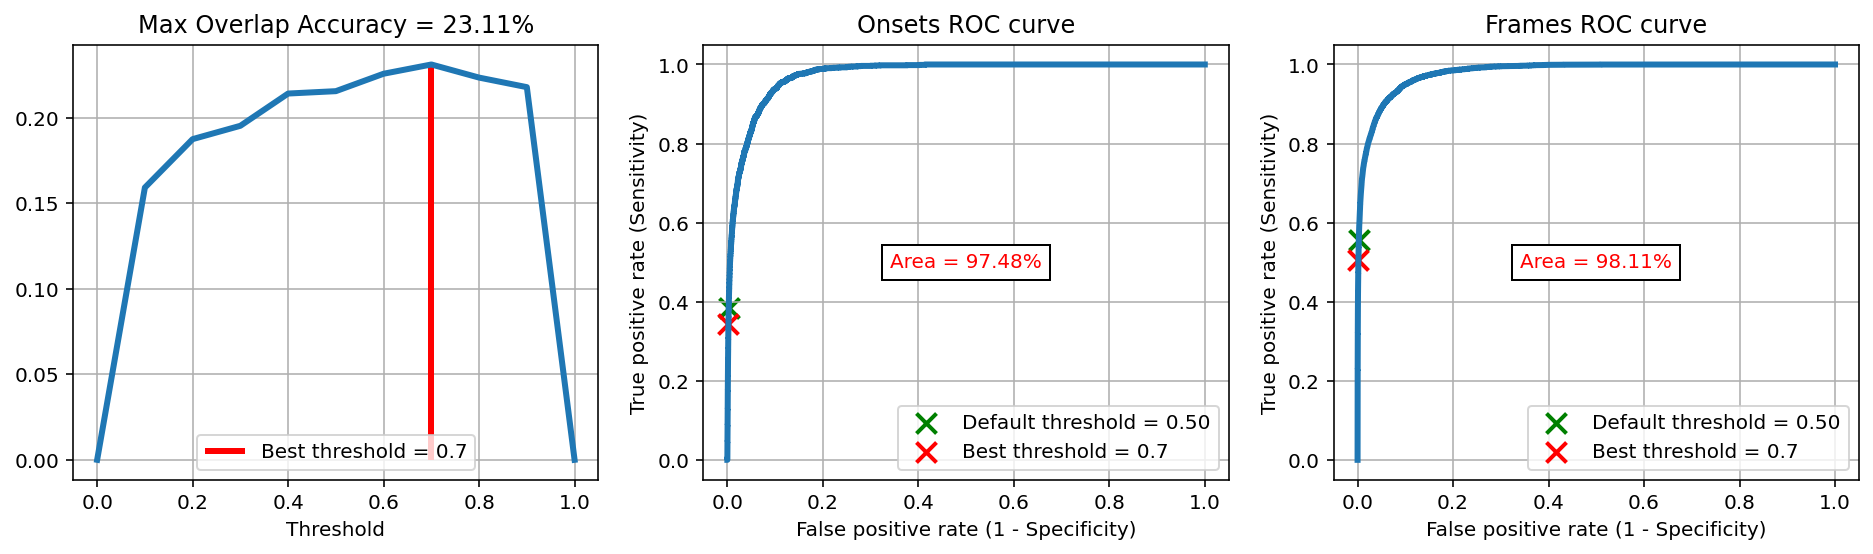

In [ ]:
mels2021, onTrue2021, offTrue2021, actTrue2021, volTrue2021 = map(lambda name: np.vstack(np.load(
#    MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 Mels
    '/content/drive/My Drive/maestro-v1.0.0/test/2021/2218 {}.npy'.format(name),
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2021 = np.pad(mels2021, [(0, -len(mels2021) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2021, offProb2021, volProb2021 = map(lambda mod: mod.predict(mels2021, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2021 = activesModel.predict([onProb2021, mels2021, offProb2021], 16, 1)
onProb2021, offProb2021, actProb2021, volProb2021 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2021)], [onProb2021, offProb2021, actProb2021, volProb2021])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2021, fps, 0, onset_predictions=onTrue2021, offset_predictions=offTrue2021,
            velocity_values=volTrue2021), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2021), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2021, offProb2021, actProb2021])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2021,  onProb2021, 'Onsets')
PlotROC(3, actTrue2021, actProb2021, 'Frames')

/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


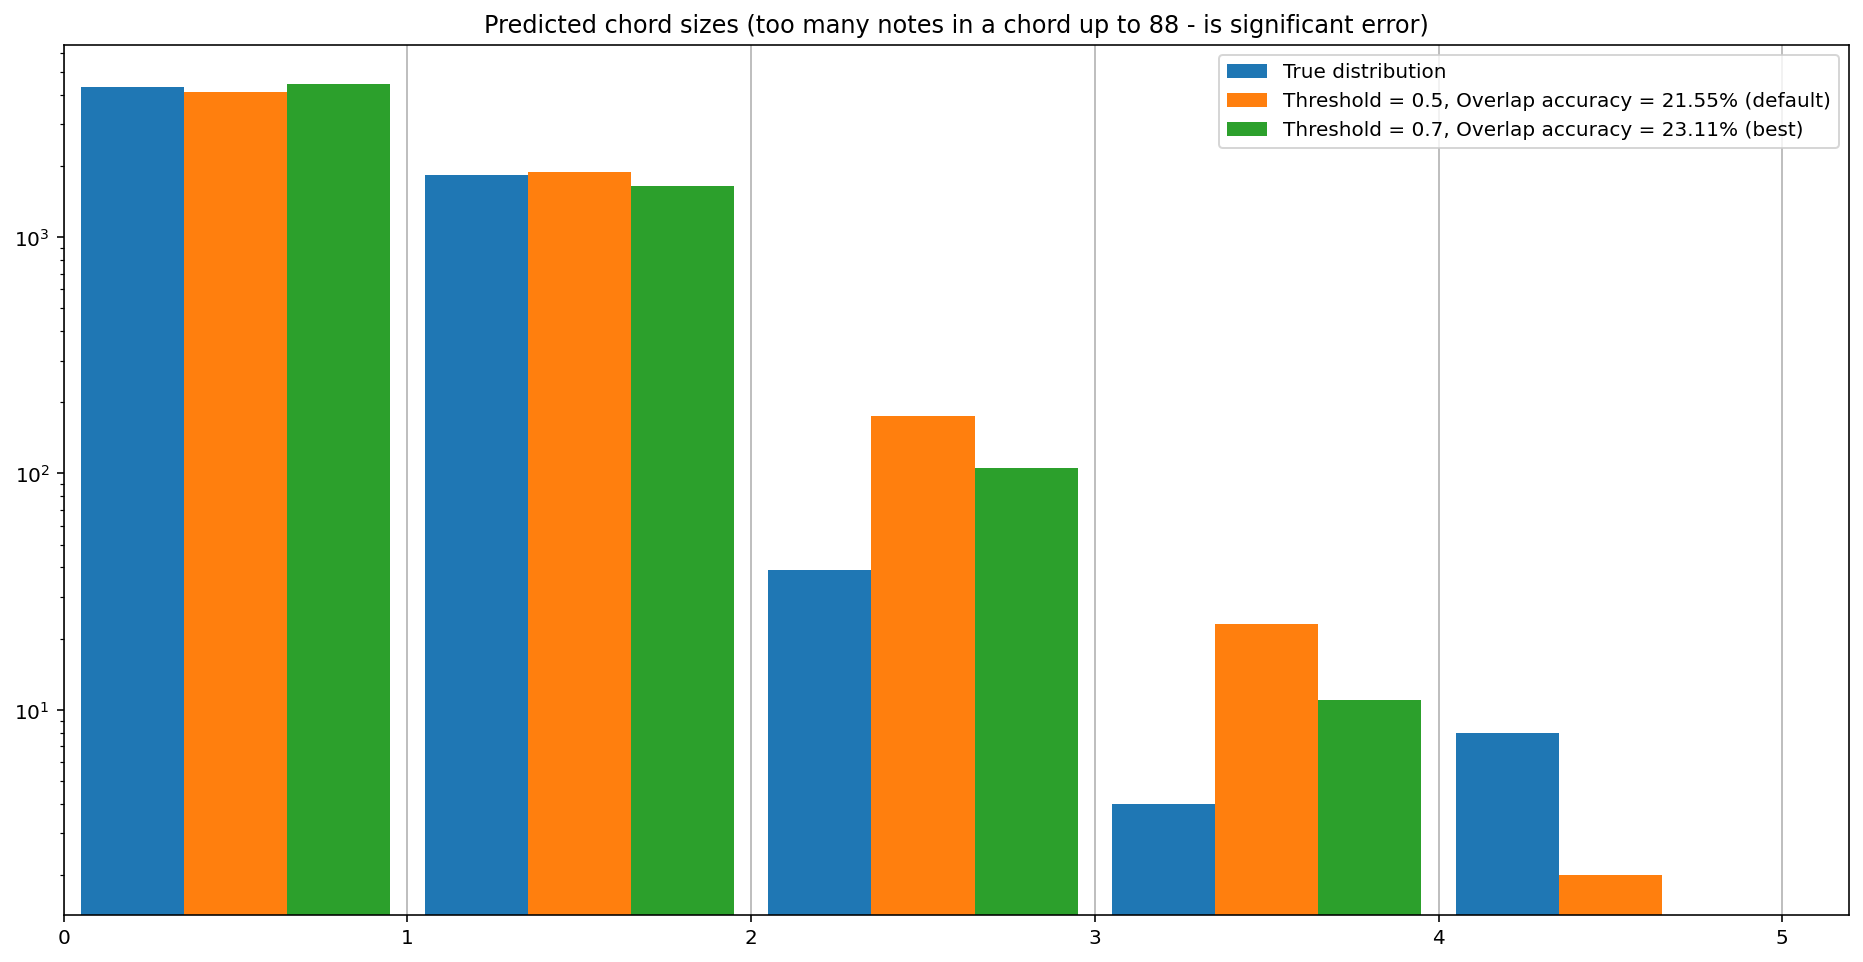

In [ ]:
yPresize, yDefault = map(lambda t: binarize(onProb2021, t).astype(int), [thBest, .5])
counts = [onTrue2021.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2021, .5),     binarize(actProb2021, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2021, thBest), binarize(actProb2021, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

2/2 [==============================] - 0s 134ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimen

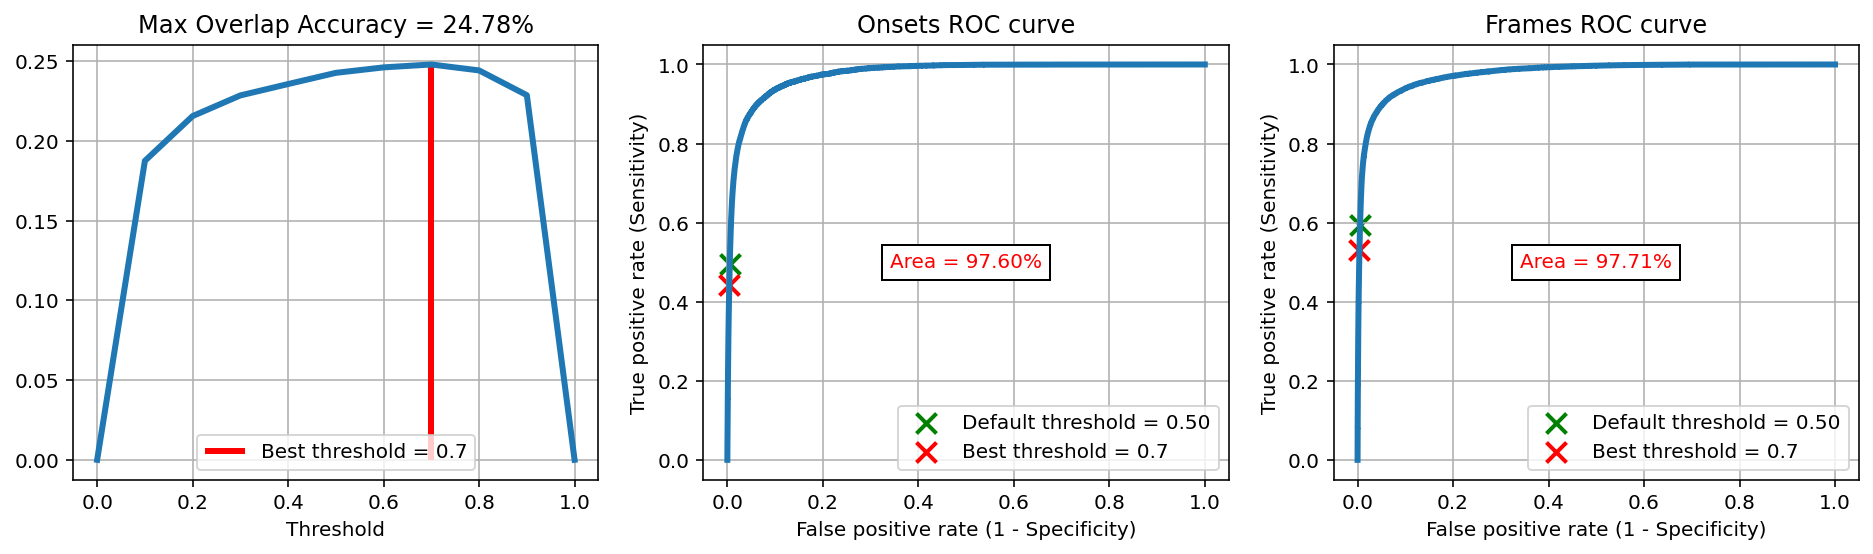

In [ ]:
mels2021, onTrue2021, offTrue2021, actTrue2021, volTrue2021 = map(lambda name: np.vstack(np.load(
#    MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 Mels
    '/content/drive/My Drive/maestro-v1.0.0/test/2021/2334 {}.npy'.format(name),
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2021 = np.pad(mels2021, [(0, -len(mels2021) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2021, offProb2021, volProb2021 = map(lambda mod: mod.predict(mels2021, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2021 = activesModel.predict([onProb2021, mels2021, offProb2021], 16, 1)
onProb2021, offProb2021, actProb2021, volProb2021 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2021)], [onProb2021, offProb2021, actProb2021, volProb2021])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2021, fps, 0, onset_predictions=onTrue2021, offset_predictions=offTrue2021,
            velocity_values=volTrue2021), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2021), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2021, offProb2021, actProb2021])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2021,  onProb2021, 'Onsets')
PlotROC(3, actTrue2021, actProb2021, 'Frames')

/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


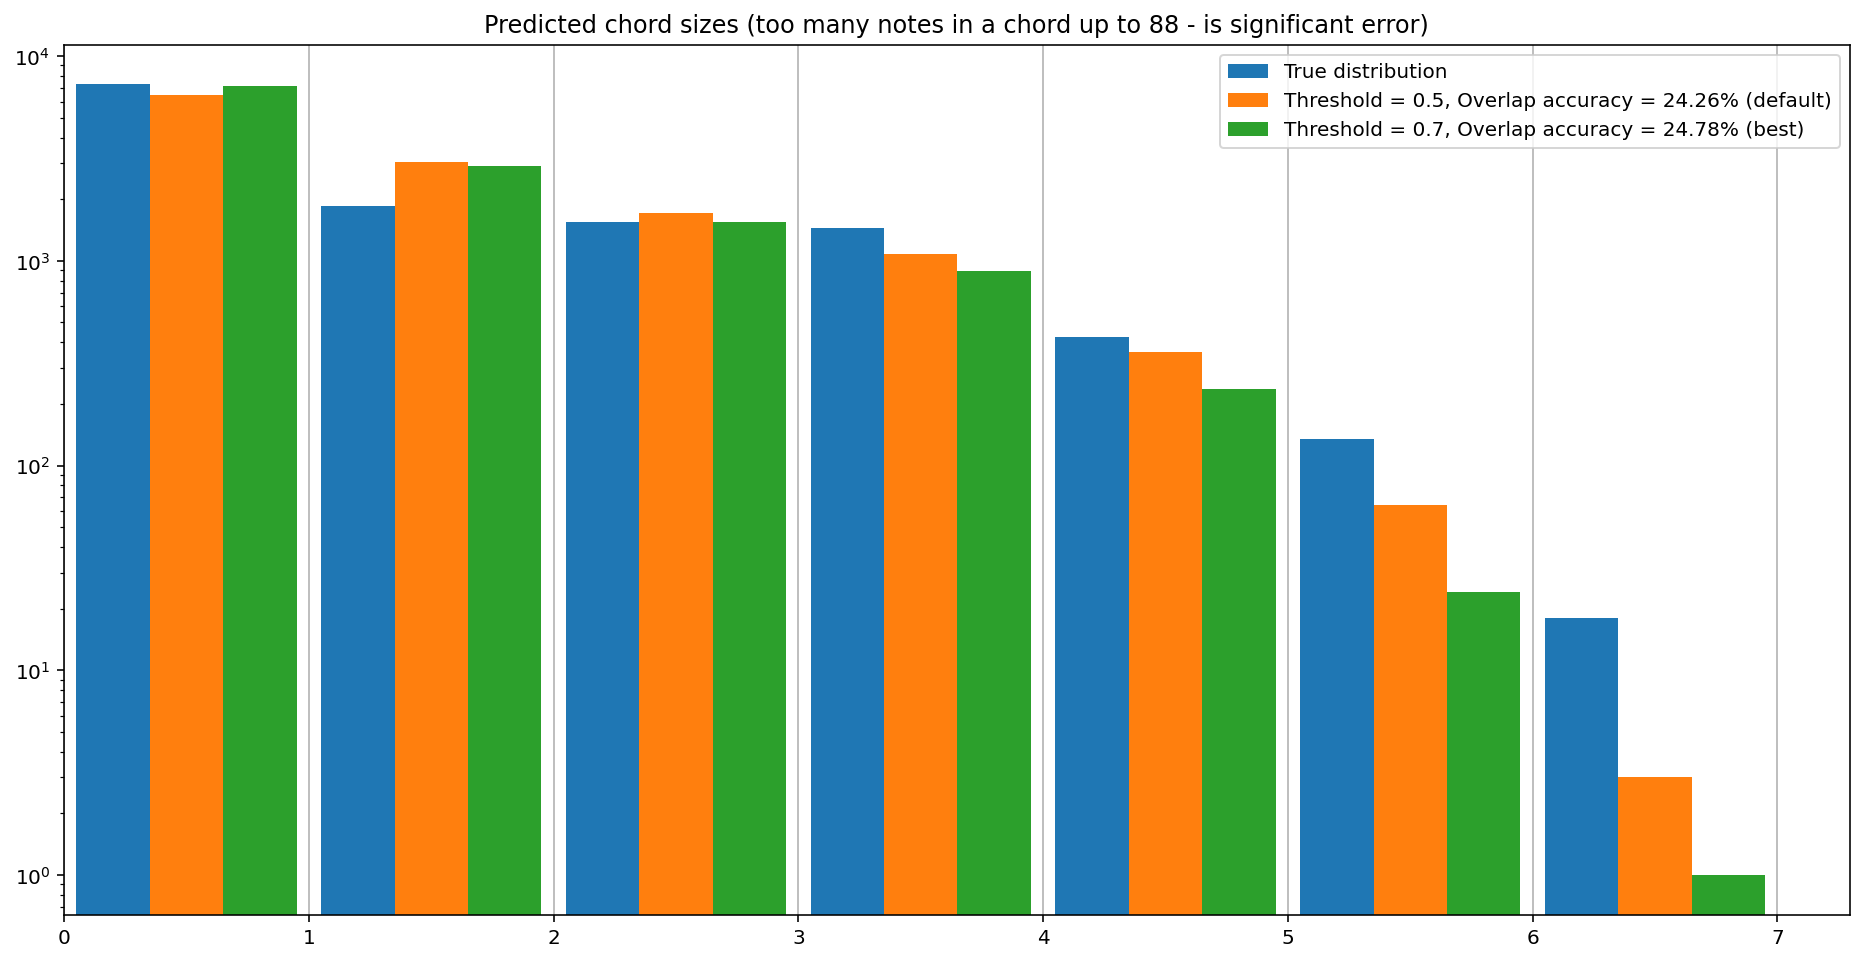

In [ ]:
yPresize, yDefault = map(lambda t: binarize(onProb2021, t).astype(int), [thBest, .5])
counts = [onTrue2021.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2021, .5),     binarize(actProb2021, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2021, thBest), binarize(actProb2021, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

# Transfer Learning Test

In [ ]:
# train/val melspectogram load 

dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = '/content/drive/My Drive/maestro-v1.0.0', -87, -85, -31, -30, 38, 41

melsTrain, melsVal = map(lambda split: np.load('{}/Mels_s {}.npy'.format(dataFolder, split), 'r'), ['train', 'validation'])
print('{} train, {} validation samples,'.format(len(melsTrain), len(melsVal)), end='\t')

melsTrainMin,  melsValMin  = map(np.min,  [melsTrain, melsVal])
melsTrainMean, melsValMean = map(np.mean, [melsTrain, melsVal])
melsTrainMax,  melsValMax  = map(np.max,  [melsTrain, melsVal])

print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
    min(melsTrainMin, melsValMin), np.mean([melsTrainMean, melsValMean]), max(melsTrainMax, melsValMax)))

2087 train, 256 validation samples,	Mels decibels in range [-77 ... -23 ... 43]


In [ ]:
fps = 16_000 / 512

onsetsModel = load_model('/content/drive/My Drive/maestro-v1.0.0/Models_s/Training Onsets Model 14.19 5.03.hdf5',compile=False)
offsetsModel = load_model('/content/drive/My Drive/maestro-v1.0.0/Models_s/Training Offsets Model 8.93 3.64.hdf5',compile=False)
activesModel = load_model('/content/drive/My Drive/maestro-v1.0.0/Models_s/Training Actives Model 61.04 0.hdf5',compile=False)
volumesModel = load_model('/content/drive/My Drive/maestro-v1.0.0/Models_s/Training Volumes Model 0.17 0.02.hdf5',compile=False)

for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        '/content/drive/My Drive/maestro-v1.0.0/test/2021 {}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(mels.split()[:-1])
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 16, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([onProb, m, offProb], 16, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    #assert abs(numOnsetsTrue - numOnsetsPred) < .1

['/content/drive/My', 'Drive/maestro-v1.0.0/test/2021']
	1 of 10
3/3 [==============================] - 179s 169ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 10
1/1 [==============================] - 0s 168ms/step
	3 of 10


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


1/1 [==============================] - 0s 168ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 10
1/1 [==============================] - 0s 167ms/step
	5 of 10


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


2/2 [==============================] - 0s 144ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 10
2/2 [==============================] - 0s 151ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 10
2/2 [==============================] - 0s 166ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 10
2/2 [==============================] - 0s 167ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 10
1/1 [==============================] - 0s 179ms/step


/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 10
2/2 [==============================] - 0s 146ms/step

Onsets: 
Precision (specificity) = 65.97%
Recall    (sensitivity) = 36.14%
F1-score                = 44.13%

Frames: 
Precision (specificity) = 45.15%
Recall    (sensitivity) = 26.34%
F1-score                = 31.62%

Volumes:
Precision (specificity) = 45.15%
Recall    (sensitivity) = 26.34%
F1-score                = 31.62%

Actual and predicted average number of onsets: 2.04 1.42
Predicts less notes than actual (specific classifier)



/usr/local/lib/python3.7/dist-packages/mir_eval/transcription_velocity.py:188: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
